In [187]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import modelos as md
from importlib import reload
reload(md)

<module 'modelos' from 'c:\\Users\\Bergson\\Desktop\\UFPB\\Quinto Período\\Machine Learning\\projeto 1\\repositorio\\Reconhecimento-de-digitos-ML-2023.2\\modelos.py'>

In [188]:
dataframe_treino = pd.read_csv('train_redu.csv', sep=';')
dataframe_teste = pd.read_csv('test_reduzido.csv', sep=';')

# Tratamento dos dados

In [189]:
# Funçao para transformar os dados em uma normal 0,1
def padronizar_normal(matriz_X):
    for i in range(np.shape(matriz_X)[1]):
        matriz_X[:,i] = (matriz_X[:,i] - np.mean(matriz_X[:,i]))/np.std(matriz_X[:,i]) # X menos media/desvio padrao

    return matriz_X

# Obtendo os valores de treino e teste
X = dataframe_treino[['intensidade', 'simetria']].values
X_teste = dataframe_teste[['intensidade', 'simetria']].values
Y = dataframe_treino['label'].values
y_teste = dataframe_teste['label'].values

# Transformando os dados e alterando os valores de label para 1 e -1
X = padronizar_normal(X)
X_teste = padronizar_normal(X_teste)

# Adicionando uma coluna de 1s
X = np.c_[np.ones(len(X)), X]
X_teste = np.c_[np.ones(len(X_teste)), X_teste]

# Usando a Regressão Logística

In [190]:
def classificador_de_todos_os_digitos_treinamento(X_treino,Y_treino, lista_digitos):
    X = X_treino.copy()
    y = Y_treino.copy()
    w_list = []
    modelo_reg_log = md.RegressaoLogistica()
    for digito in lista_digitos:     
        y_binario = np.where(y == digito, 1, -1)

        w, acuracia, y_pred_treino = modelo_reg_log.fit(X.T, y_binario) # Passo o X.transpose() para que a multiplicação de matrizes seja possível
        w_list.append(w)

        # plotando o gráfico
        modelo_reg_log.plot_grafico(X, y_pred_treino, digito, -1)
        

        # obtenha o indice dos valores de y_pred_treino que são 1 e retirando os elementos correspondentes em X e Y
        indices = np.where(y_pred_treino == 1)[0]
        X = np.delete(X, indices, axis=0)
        y = np.delete(y, indices, axis=0)

        print(f"acuracia do digito {digito}: {acuracia}")

    return w_list




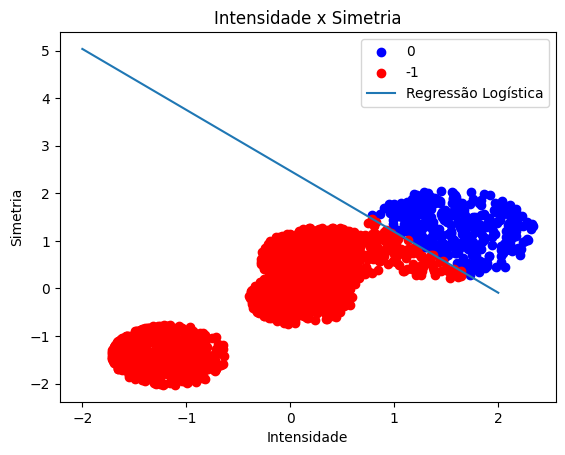

acuracia do digito 0: 95.24245196706312


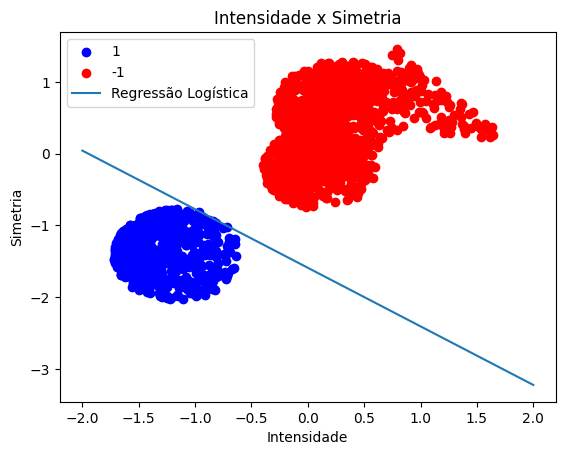

acuracia do digito 1: 100.0


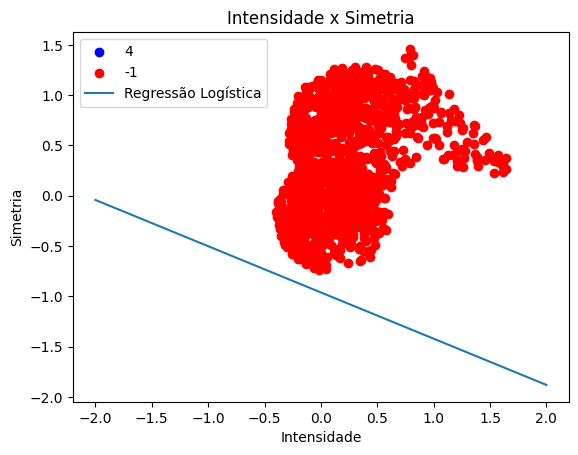

acuracia do digito 4: 54.09705648369133


[array([-0.00111102,  0.00057592,  0.00044959]),
 array([-0.00084791, -0.00043548, -0.00053371]),
 array([-0.00058184, -0.00027801, -0.00060469])]

In [191]:
digitos = [0,1,4]
w_treino_list = classificador_de_todos_os_digitos_treinamento(X, Y, digitos)
w_treino_list


# Usando a Regressão Linear

### Treinando o modelo

In [192]:
def classificador_de_todos_os_digitos_treinamento_RL(X_treino,Y_treino,  X_teste, Y_teste, lista_digitos):
    X = X_treino.copy()
    y = Y_treino.copy()
    x_teste = X_teste.copy()
    y_teste = Y_teste.copy()
    modelo_reg_ln = md.RegressaoLinear()

    for digito in lista_digitos:     
        y_binario_treino = np.where(y == digito, 1, -1)
        y_binario_teste = np.where(y_teste == digito, 1, -1)

        #treinando o modelo com os dados de treino
        w = modelo_reg_ln.fit(X, y_binario_treino)
        y_pred_treino = modelo_reg_ln.atribuicao_de_classes(X) 
        #utilizando os dados de teste com o w encontrado no treino
        y_pred_teste = modelo_reg_ln.atribuicao_de_classes(x_teste)

        # Relatorio do treino
        print('Acuracia do treino:', modelo_reg_ln.calculate_accuracy(y_pred_treino, y_binario_treino))
        print('Matriz de confusão do treino, os valores do digito estao na linha de baixo')
        matriz_de_confusao_treino = confusion_matrix(y_binario_treino, y_pred_treino)
        print(matriz_de_confusao_treino)
        print(classification_report(y_binario_treino, y_pred_treino, target_names=[f'{digito}', '-1']))
        # Gráfico do treino
        print('Gráfico de treino')
        modelo_reg_ln.plot_grafico(X, y_pred_treino, digito, -1)

        # Relatório do teste
        print('Acuracia do teste:', modelo_reg_ln.calculate_accuracy(y_pred_teste, y_binario_teste))
        matriz_de_confusao_teste = confusion_matrix(y_binario_teste, y_pred_teste)
        print(matriz_de_confusao_teste)
        print(classification_report(y_binario_teste, y_pred_teste, target_names=[f'{digito}', '-1']))
        print('Gráfico de teste')
        # plotando o gráfico de teste
        modelo_reg_ln.plot_grafico(x_teste, y_pred_teste, digito, -1)
        

        # obtenha o indice dos valores de y_pred_treino que são 1 e retirando os elementos correspondentes em X e Y
        indices = np.where(y_pred_treino == 1)[0]
        X = np.delete(X, indices, axis=0)
        y = np.delete(y, indices, axis=0)
        indices_teste = np.where(y_pred_teste == 1)[0]
        x_teste = np.delete(x_teste, indices_teste, axis=0)
        y_teste = np.delete(y_teste, indices_teste, axis=0)




Acuracia do treino: 95.28819762122598
Matriz de confusão do treino, os valores do digito estao na linha de baixo
[[1761    0]
 [ 103  322]]
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1761
          -1       1.00      0.76      0.86       425

    accuracy                           0.95      2186
   macro avg       0.97      0.88      0.92      2186
weighted avg       0.96      0.95      0.95      2186

Gráfico de treino


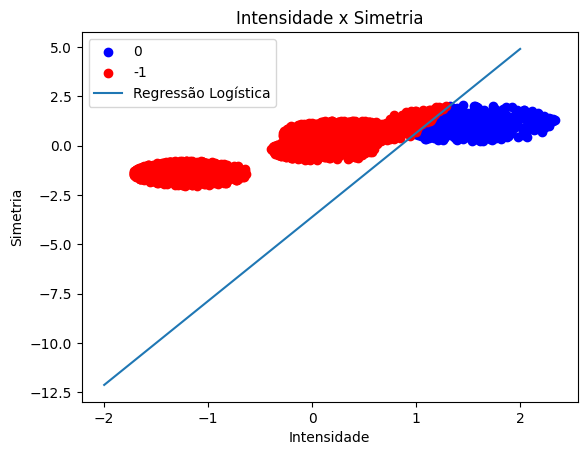

Acuracia do teste: 96.05381165919282
[[897   0]
 [ 44 174]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       897
          -1       1.00      0.80      0.89       218

    accuracy                           0.96      1115
   macro avg       0.98      0.90      0.93      1115
weighted avg       0.96      0.96      0.96      1115

Gráfico de teste


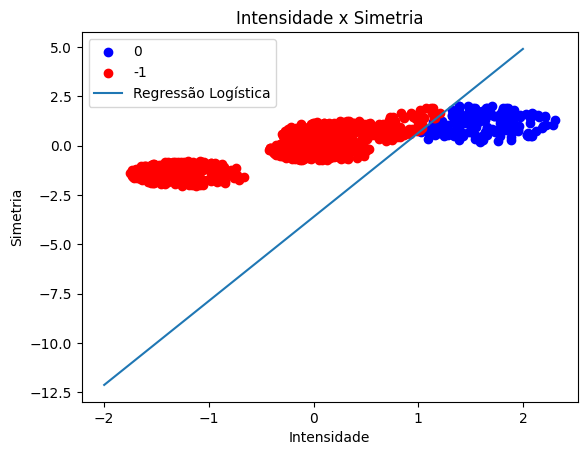

Acuracia do treino: 100.0
Matriz de confusão do treino, os valores do digito estao na linha de baixo
[[1256    0]
 [   0  608]]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      1256
          -1       1.00      1.00      1.00       608

    accuracy                           1.00      1864
   macro avg       1.00      1.00      1.00      1864
weighted avg       1.00      1.00      1.00      1864

Gráfico de treino


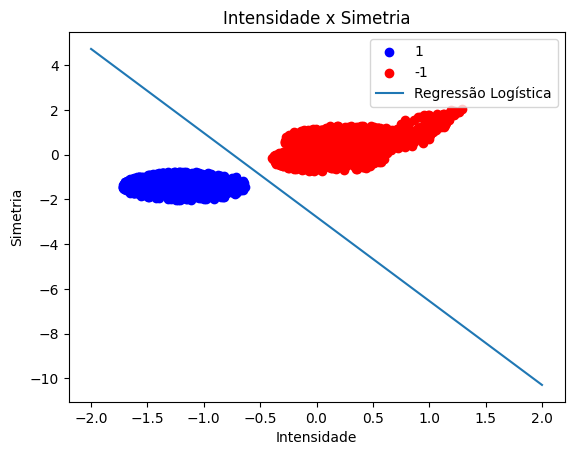

Acuracia do teste: 100.0
[[649   0]
 [  0 292]]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       649
          -1       1.00      1.00      1.00       292

    accuracy                           1.00       941
   macro avg       1.00      1.00      1.00       941
weighted avg       1.00      1.00      1.00       941

Gráfico de teste


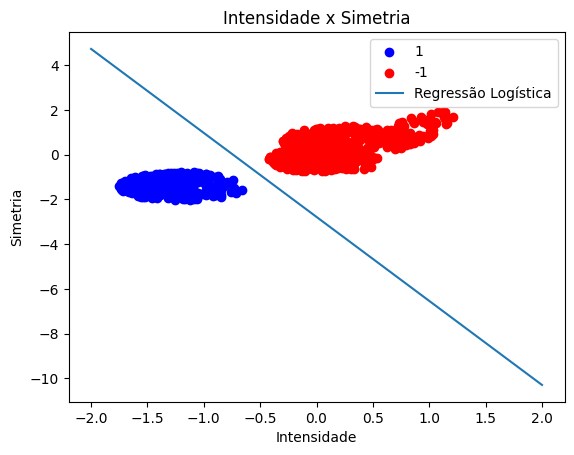

Acuracia do treino: 92.67515923566879
Matriz de confusão do treino, os valores do digito estao na linha de baixo
[[603  76]
 [ 16 561]]
              precision    recall  f1-score   support

           4       0.97      0.89      0.93       679
          -1       0.88      0.97      0.92       577

    accuracy                           0.93      1256
   macro avg       0.93      0.93      0.93      1256
weighted avg       0.93      0.93      0.93      1256

Gráfico de treino


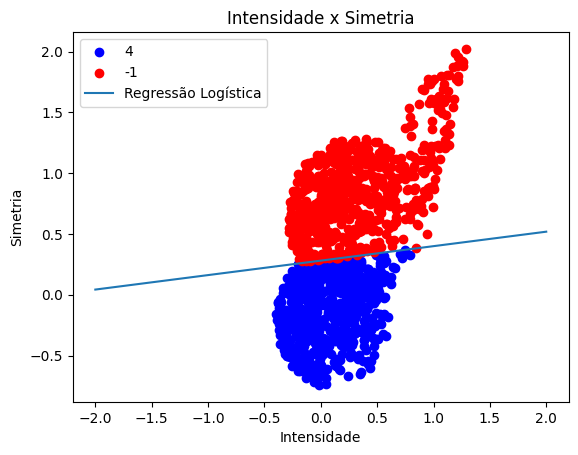

Acuracia do teste: 94.60708782742681
[[303  32]
 [  3 311]]
              precision    recall  f1-score   support

           4       0.99      0.90      0.95       335
          -1       0.91      0.99      0.95       314

    accuracy                           0.95       649
   macro avg       0.95      0.95      0.95       649
weighted avg       0.95      0.95      0.95       649

Gráfico de teste


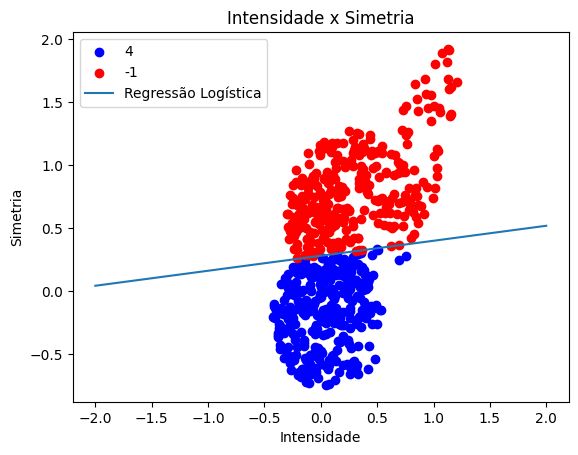

In [193]:
digitos = [0,1,4]
classificador_de_todos_os_digitos_treinamento_RL(X, Y, X_teste, y_teste, digitos)

